# f-GAN

## Theory

$f$-divergence (a.k.a., Ali-Silvey distance):

$$D_f(P || Q) = \int_\mathcal{X} q(x) f \left(\frac{p(x)}{q(x)} \right) dx,$$

where the generator function $f: \mathbb{R}_+ \rightarrow \mathbb{R}$ is a convex, lower-semicontinuous function satisfying $f(1) = 0$.

Different choices of f recover popular divergences as special cases. 

For example, 

1. $f(u) = \frac{1}{2} |u - 1|$ for Total Variation (TV); 
2. $f(u) = u \log u$ for Kullback-Leibler (KL) divergence; 
3. $f(u) = - \log u$ for Reverse KL divergence; 
4. $f(u) = (u - 1)^2$ for Pearson's $\chi^2$ distance; 
5. $f(u) = (\sqrt{u} - 1)^2$ for Squared Hellinger distance; 
6. $f(u) = - (u + 1) \log \frac{1 + u}{2} + u \log u$ for Jensen-Shannon (JS) divergence; 

and so on.

## Advantages and Limitations



## References

S. Nowozin, B. Cseke, and R. Tomioka, f-GAN: Training Generative Neural Samplers using Variational Divergence Minimization, NIPS 2016.

In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True, source_url= 'http://yann.lecun.com/exdb/mnist/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
mb_size = 128
X_dim = X_dim = mnist.train.images.shape[1]
Z_dim = 100
h_dim = 128

lr = 1e-3

+ Initialization

In [4]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [5]:
X = tf.placeholder(tf.float32, shape=[None, X_dim])

D_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

+ Latent/hidden variable $z$ can sample from any distributions, e.g., uniform distribution or normal distribution.

In [6]:
def sample_Z(m, n):
    
    return np.random.uniform(-1., 1., size=[m, n])

+ Generator $G$ and Discriminator $D$ are two networks, e.g., ConvNets or Multi-Layer Perceptrons (MLP). Here, Two-Layer Full-Connected Forward Feedback NN.

In [7]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)
    
    return G_prob

def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    
    return D_logit

In [8]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)
    
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
        
    return fig

In [9]:
G_sample = generator(Z)

D_real = discriminator(X)
D_fake = discriminator(G_sample)

+ Loss functions

In [10]:
# Uncomment D_loss and its respective G_loss of your choice
# ---------------------------------------------------------
""" Total Variation """
# D_loss = -(tf.reduce_mean(0.5 * tf.nn.tanh(D_real)) - tf.reduce_mean(0.5 * tf.nn.tanh(D_fake)))
# G_loss = -tf.reduce_mean(0.5 * tf.nn.tanh(D_fake))

""" Forward KL """
# D_loss = -(tf.reduce_mean(D_real) - tf.reduce_mean(tf.exp(D_fake - 1)))
# G_loss = -tf.reduce_mean(tf.exp(D_fake - 1))

""" Reverse KL """
# D_loss = -(tf.reduce_mean(-tf.exp(D_real)) - tf.reduce_mean(-1 - D_fake))
# G_loss = -tf.reduce_mean(-1 - D_fake)

""" Pearson Chi-squared """
D_loss = -(tf.reduce_mean(D_real) - tf.reduce_mean(0.25*D_fake**2 + D_fake))
G_loss = -tf.reduce_mean(0.25*D_fake**2 + D_fake)

""" Squared Hellinger """
# D_loss = -(tf.reduce_mean(1 - tf.exp(D_real)) - tf.reduce_mean((1 - tf.exp(D_fake)) / (tf.exp(D_fake))))
# G_loss = -tf.reduce_mean((1 - tf.exp(D_fake)) / (tf.exp(D_fake)))

D_solver = (tf.train.AdamOptimizer(learning_rate=lr).minimize(D_loss, var_list=theta_D))
G_solver = (tf.train.AdamOptimizer(learning_rate=lr).minimize(G_loss, var_list=theta_G))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


+ Here, $k = 1$

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('GAN-f-GAN/'):
    os.makedirs('GAN-f-GAN/')

avg_costs = {'discriminator': [], 'generator': []}

i = 0

for it in range(50000):
    X_mb, _ = mnist.train.next_batch(mb_size)
    Z_mb = sample_Z(mb_size, Z_dim)
    
    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: Z_mb})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: Z_mb})
    
    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D_loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print('\n')
        
        n_sample = 16
        
        samples = sess.run(G_sample, feed_dict={Z: sample_Z(n_sample, Z_dim)})

        fig = plot(samples)
        plt.savefig('GAN-f-GAN/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)
        
        avg_costs['discriminator'].append(D_loss_curr / n_sample)
        avg_costs['generator'].append(G_loss_curr / n_sample)

Iter: 0
D_loss: -0.2754
G_loss: 0.9321


Iter: 1000
D_loss: -8.744
G_loss: -5.279


Iter: 2000
D_loss: -14.29
G_loss: -14.06


Iter: 3000
D_loss: -40.11
G_loss: -10.49


Iter: 4000
D_loss: -13.9
G_loss: -22.23


Iter: 5000
D_loss: -19.48
G_loss: -15.4


Iter: 6000
D_loss: -5.582
G_loss: -16.9


Iter: 7000
D_loss: 11.11
G_loss: -32.59


Iter: 8000
D_loss: -13.89
G_loss: -11.78


Iter: 9000
D_loss: -12.38
G_loss: -9.634


Iter: 10000
D_loss: -35.54
G_loss: -10.41


Iter: 11000
D_loss: -88.9
G_loss: -44.99


Iter: 12000
D_loss: -57.64
G_loss: -51.85


Iter: 13000
D_loss: -338.7
G_loss: -58.97


Iter: 14000
D_loss: 239.9
G_loss: -255.1


Iter: 15000
D_loss: -7.032
G_loss: -25.48


Iter: 16000
D_loss: -2.645
G_loss: -23.13


Iter: 17000
D_loss: -112.0
G_loss: -39.66


Iter: 18000
D_loss: -331.4
G_loss: -72.04


Iter: 19000
D_loss: -73.9
G_loss: -59.53


Iter: 20000
D_loss: -121.3
G_loss: -66.62


Iter: 21000
D_loss: -336.4
G_loss: -56.18


Iter: 22000
D_loss: -540.4
G_loss: -78.38


Iter: 2

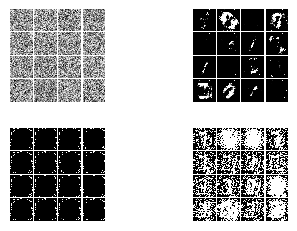

In [12]:
plt.figure()

ax = plt.subplot(221)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan1 = plt.imread('GAN-f-GAN/000.png')
plt.imshow(gan1, cmap='Greys_r')

ax = plt.subplot(222)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan2 = plt.imread('GAN-f-GAN/015.png')
plt.imshow(gan2, cmap='Greys_r')

ax = plt.subplot(223)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan3 = plt.imread('GAN-f-GAN/030.png')
plt.imshow(gan3, cmap='Greys_r')

ax = plt.subplot(224)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan4 = plt.imread('GAN-f-GAN/045.png')
plt.imshow(gan4, cmap='Greys_r')

plt.show()

+ Performance estimation

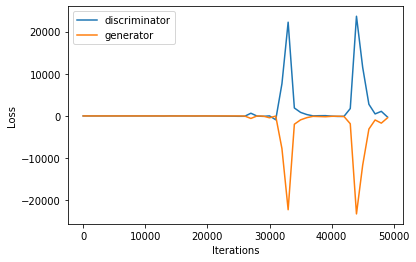

In [13]:
# plotting the learning curves
plt.figure()
plt.plot(np.arange(len(avg_costs['discriminator']))*1000, avg_costs['discriminator'], label='discriminator')
plt.plot(np.arange(len(avg_costs['generator']))*1000, avg_costs['generator'], label='generator')
plt.xlabel(r'Iterations')
plt.ylabel(r'Loss')
plt.legend()
plt.show()